# This Notebook serves as a demo of the model used to forecast volume, handle time and aht.

Run the functions in the 1st two cells below by clicking the play button (>) once, and then, in the 3rd cell, fill out the form to set the start and end date of training and the end of the testing period, the metric, and confidence interval that you'd like to forecast.

*email me with any errors you encounter*

In [101]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import datetime
import os
from google.colab import drive

In [102]:
!wget -q --show-progress --no-check-certificate 'https://drive.google.com/uc?export=download&id=1KJHCkgVGvIwA4599rAdy8Zlf_3njkusA' -O full_dataset.csv

!wget -q --show-progress --no-check-certificate 'https://drive.google.com/uc?export=download&id=1TdoIwEWGd9tj0A4SsbezdWFBOJoxrgfD' -O holidays.csv

!wget -q --show-progress --no-check-certificate 'https://drive.google.com/uc?export=download&id=1yLvOj8TNDQuYYaEcgFNpoQBFVQbJHuJY' -O monthly_volume.csv

!wget -q --show-progress --no-check-certificate 'https://drive.google.com/uc?export=download&id=1qLvccSOGAnWEo3UEQK7A74JaKovwsHZP' -O arima_results_volume.csv

!wget -q --show-progress --no-check-certificate 'https://drive.google.com/uc?export=download&id=1h47YpQgPhPbcyCK2ur6bkQE0vDp4FiL9' -O date_dict.json

full_dataset.csv    100%[===================>]   1.24M  --.-KB/s    in 0.01s   
holidays.csv        100%[===================>]     583  --.-KB/s    in 0s      
monthly_volume.csv  100%[===================>]   1.02K  --.-KB/s    in 0s      
arima_results_volum 100%[===================>]     876  --.-KB/s    in 0s      
date_dict.json      100%[===================>]   1.64K  --.-KB/s    in 0s      


In [103]:
#@title Split and Load Data by Business Line

import pandas as pd

def load_full_dataset(path):
    """
    given a dataset with all business units
    return and write to each csv
    """
    df = pd.read_csv(path)
    
    df.rename(columns={'ACTIVITY DATE':'date', 
                       'Sum of TOTAL TIME - AHT (sec)':'handle_time', 
                       'Sum of TOTAL TIME - AHT - FORECAST (sec)': 'handle_time_forecast', 
                       'Sum of VOLUME - RECEIVED': 'volume', 
                       'Sum of VOLUME - FORECAST': 'volume_forecast', 
                       'Sum of VOLUME - HANDLED': 'volume_handled'}, inplace=True)
    
    df.columns = [x.lower() for x in df.columns]
    
    return df

path = '../content/full_dataset.csv'
df = load_full_dataset(path)
df.tail()

def write_data(df, group='business line', 
forecast_list=['handle_time','handle_time_forecast', 
'volume', 'volume_forecast', 'volume_handled']):
    """
    take in a dataframe, query by business unit 
    and write to a csv
    """
    # iterate through the unique business lines
    for g in df[group].unique():
        path = '../content/' + g + '_aht_vol.csv'
        path = path.replace(' ', '-')
        df.loc[df.loc[:, group] == g, ['date']+forecast_list].to_csv(path)
        print('wrote to '+path)

write_data(df)
date_dict = None

wrote to ../content/WISE-Contractual_aht_vol.csv
wrote to ../content/CS-Alaska_aht_vol.csv
wrote to ../content/CS-John-Hancock_aht_vol.csv
wrote to ../content/CS-Maryland_aht_vol.csv
wrote to ../content/CS-National_aht_vol.csv
wrote to ../content/RIS_aht_vol.csv
wrote to ../content/RCS-PHONES_aht_vol.csv
wrote to ../content/BRO_aht_vol.csv
wrote to ../content/PSG_aht_vol.csv
wrote to ../content/BRO-Complex_aht_vol.csv


In [104]:
# !pip install prophet

In [105]:
def load_data(path, holidays=False):
    """
    using a path to a bu dataset return the dataframe
    """
    # create a pandas dataframe object
    df = pd.read_csv(path, index_col=0,
                     parse_dates=['date'])
    
    # convert strings to numbers
#     df['volume_forecast'] = pd.to_numeric(df['volume_forecast'])
#     df['volume_handled'] = pd.to_numeric(df['volume_handled'])
    
    # create column for aht
    if holidays is False:
        df = remove_holidays(df)

    df.loc[:,'aht'] = df.loc[:, 'handle_time'].values / df.loc[:, 'volume_handled'].values
    df.loc[:,'aht_forecast'] = df.loc[:, 'handle_time_forecast'].values / df.loc[:, 'volume_forecast'].values
    df.loc[:,'abandonment_rate'] = (df.loc[:, 'volume'].values - df.loc[:, 'volume_handled'].values) / df.loc[:, 'volume'].values
    df.loc[:,'workload'] = df.loc[:, 'handle_time'].values / 3600


    df.index = df.loc[:, 'date'].values
    # display(df.tail(10))
    return df

In [106]:
#@title Instantiate Functions

def remove_holidays(df, path='../content/holidays.csv'):
    """
    take in a holidays csv of dates and return
    a filtered dataframe
    """
    
    holidays = pd.read_csv(path)
    
    if 'ds' not in df.columns:
        date_marker = 'date'
    else:
        date_marker = 'ds'
    
    return df.loc[(~df.loc[:, date_marker].dt.weekday.isin([5,6])) & (~df.loc[:, date_marker].isin(holidays.iloc[:,0].tolist()))]

def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    

def clean_training_data(df, holidays=False):
    """
    take in a dataframe and return a filtered dataframe
    """

    # remove holidays and weekends
    if not holidays:
        df = remove_holidays(df)
    
    ## remove zeros
    # df = df.loc[(df.loc[:,'aht'] > 400) | (df.loc[:, 'aht'] < 900) | (df.loc[:, 'handle_time'] > 500000)]
    
    # remove nulls
    df = df.loc[df.loc[:, 'aht'].notnull()]

    return df

def create_training_data(df, kpi, start, end, freq=None):
    """
    takes in a dataframe and returns a filtered dataframe
    """

    if kpi == 'abandonment_rate':
        df.loc[:,kpi] = np.log10(1 + df.loc[:, kpi].values)
    df = df.loc[(df.loc[:, 'date'] >= start) & (df.loc[:, 'date'] < end)]
    
    df = pd.DataFrame(df.loc[:, kpi])
    df = df.reset_index()
    df.columns = ['ds', 'y']
    return df

def is_holiday_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 11 or date.month < 5)

def is_tax_day(ds):
    date = pd.to_datetime(ds)
    return (date.year == 2021 and date.month == 5 and date.day > 17)

def is_lockdown(ds):
    date = pd.to_datetime(ds)
    return ((date.year == 2020) & (date.month >= 3) & (date.month < 6))

def train_model(df, kpi, ci=0.95):
    """
    takes in a dataframe with 2 cols
    'ds' and 'y' and returns a prediction
    """

    df.loc[:,'on_season'] = df.loc[:,'ds'].apply(is_holiday_season)
    df.loc[:,'off_season'] = ~df.loc[:,'ds'].apply(is_holiday_season)
    df.loc[:,'on_tax_day'] = df.loc[:,'ds'].apply(is_tax_day)
    df.loc[:,'off_tax_day'] = ~df.loc[:,'ds'].apply(is_tax_day)

    m = (Prophet(daily_seasonality=False, weekly_seasonality='auto', 
                 yearly_seasonality=30)
    # .add_seasonality(name='weekly', period=5, fourier_order=6)
    # .add_seasonality(name='monthly', period=21, fourier_order=4)
    # .add_seasonality(name='quarterly', period=52/4, fourier_order=6)
    # .add_seasonality(name='yearly', period=52, fourier_order=5)
    .add_seasonality(name='weekly_on_season', period=7, fourier_order=6, condition_name='on_season')
    .add_seasonality(name='weekly_off_season', period=7, fourier_order=6, condition_name='off_season')
    .add_seasonality(name='late_tax_on_day', period=7, fourier_order=6, condition_name='on_tax_day')
    .add_seasonality(name='late_tax_off_day', period=7, fourier_order=6, condition_name='off_tax_day')
    )  
   
    m.add_country_holidays(country_name='US')
    m.fit(df)
    
    return m

def get_validation_data(df, start_test, end_test):
    """
    take in a dataframe and return a dataframe filtered after the end of training
    """
    date_marker = 'date'
    df = remove_holidays(df)
    if 'ds' in df.columns:
        date_marker = 'ds'
    elif 'date' not in df.columns:
        return df.loc[start_test:end_test]   
    
    return df.loc[(df.loc[:, date_marker] >= start_test) & (df.loc[:, date_marker] < end_test)]

def get_accuracy(df2,forecast, kpi, metric='mae'):
    """
    take in 2 dataframes df2 with original predictions and forecast with
    new predictions and return a dataframe of the MAE for each model and
    the difference between old model and prophet
    negative values indicate old model has less error.
    """
    if metric == 'mape':
        mae1 = mean_absolute_percentage_error(df2.loc[:,kpi].values, df2.loc[:,kpi+'_forecast'].values)
        mae2 = mean_absolute_percentage_error(df2.loc[:,kpi].values, forecast.loc[:,'yhat'].values)
    elif metric == 'mae':
        mae1 = mean_absolute_error(df2.loc[:, kpi].values, df2.loc[:, kpi+'_forecast'].values)
        mae2 = mean_absolute_error(df2.loc[:, kpi].values, forecast.loc[:, 'yhat'].values)
    elif metric == 'rmse':
        mae1 = np.sqrt(mean_squared_error(df2.loc[:, kpi].values, df2.loc[:, kpi+'_forecast'].values))
        mae2 = np.sqrt(mean_squared_error(df2.loc[:, kpi].values, forecast.loc[:,'yhat'].values))
        
    diff = mae1- mae2
    return pd.DataFrame(index=['old model', 'prophet', 'difference'], 
                 data=[mae1,mae2,diff],
                 columns=[metric])

def get_performance(name_dict, data, fields, start_train, end_train, 
                    start_test, end_test, metric, ci=0.95, periods=1460, 
                    train_holidays=True, show_plots=True, 
                    show_components=False, show_table=True):
    """
    take in data as a list of csv from each business unit
    fields are the kpis being predicted
    start and end is the start date and end date of testing
    
    TODO
        setup model diagnostics
        https://facebook.github.io/prophet/docs/diagnostics.html
    """
    
    res = {}
    # create a list for the scores of each kpi
    a = []
    bu = data
    # print('*'*80)
    # print('Training Model for ', name_dict[bu])
    # print('*'*80)
    for k in fields:  
        kpi = k
        start = start_test
        end = end_test

        df = load_data(bu, holidays=train_holidays)

        cleaned = clean_training_data(df, holidays=train_holidays)

        cleaned.to_csv('cleaned.csv', index=False)
        
        df2 = get_validation_data(cleaned, start_test=start_test, end_test=end_test)

        df = create_training_data(cleaned, kpi, start_train, end_train)

        m = train_model(df, kpi, ci=ci)

        future = m.make_future_dataframe(periods=periods)

        future = remove_holidays(future)
        future.loc[:, 'on_season'] = future.loc[:,'ds'].apply(is_holiday_season).values
        future.loc[:, 'off_season'] = ~future.loc[:,'ds'].apply(is_holiday_season).values
        
        future.loc[:, 'on_tax_day'] = future.loc[:,'ds'].apply(is_tax_day).values
        future.loc[:, 'off_tax_day'] = ~future.loc[:,'ds'].apply(is_tax_day).values

        forecast = m.predict(future)

        forecast.to_csv('forecast.csv', index=False)
        df.to_csv('history.csv', index=False)
        if show_plots:
            fig = m.plot(forecast)
            plt.title(k)
            if show_components:
                fig2 = m.plot_components(forecast)
            plt.show()

        os.makedirs('../content/future', exist_ok=True)
        forecast.loc[forecast.loc[:, 'ds'] >= end_test].to_csv('../content/future/' + k + '_' + start_train + '_' + end_train + '_' + start_test + '_' + end_test + '_RIS.csv')
        f = forecast.copy()
        f = f.loc[(f.loc[:, 'ds'] >= start_test) & (f.loc[:, 'ds'] < end_test)]
        
        f = f.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)

        write_f = f.copy()
        write_f = write_f.loc[:, ['ds','yhat_lower', 'yhat', 'yhat_upper']]

        dfc = df2.copy()
        dfc = pd.DataFrame(df2.loc[:, kpi])
        write_f = pd.concat([write_f, dfc], 1)
        
        write_f.loc[:,'error_prophet'] = np.abs(write_f.loc[:, 'yhat'].values - write_f.loc[:, k].values)

        if kpi != 'abandonment_rate':
            write_f.loc[:, 'error_prophet'] = write_f.loc[:, 'error_prophet'].round().values
            write_f = pd.concat([write_f, pd.DataFrame(df2.loc[:, k+'_forecast'])], 1)
            write_f.loc[:, 'error_forecast'] = np.abs(write_f.loc[:, k+'_forecast'].values - write_f.loc[:, k]).round().values
            write_f.loc[:, 'diff'] = write_f.loc[:, 'error_forecast'].values - write_f.loc[:, 'error_prophet'].values
            accuracy = get_accuracy(df2, f, kpi, metric=metric )
            a.append(accuracy)

            os.makedirs('../content/predictions', exist_ok=True)
            if k == 'handle_time':
                k = 'handletime'
            write_f.to_csv(
                '../content/predictions/' + k + '_' + start_train + '_' + end_train + '_' + start_test + '_' + end_test + '_' + business_unit + '.csv')

        write_f.loc[:, 'mape_forecast'] = np.abs(write_f.loc[:, kpi].values - write_f.loc[:, kpi+'_forecast'].values) / write_f.loc[:, kpi].values * 100
        write_f.loc[:, 'mape_prophet'] = np.abs(write_f.loc[:, kpi].values - write_f.loc[:, 'yhat'].values) / write_f.loc[:, kpi].values * 100
        if show_table:
            display(write_f)

    diff = None
    diff = pd.concat([x for x in a], axis=1)
    diff.columns = [x for x in fields]
    if metric != 'mape' and kpi == 'handle_time':
        diff.loc[:, 'handle_time'] /= 3600
        diff.rename(columns={'handle_time': 'workload (hours)'}, inplace=True)
    # print(metric, name_dict[bu])

    if show_table:   
        display(diff)
    
    f_copy = forecast.copy()
    f_copy = f_copy.loc[f_copy.loc[:, 'ds'] >= end_test]

    res[bu] = (m, diff, f_copy, forecast, write_f)
    return res
print('done instantiating functions')

done instantiating functions


# The forecasting tool below returns performance and predictions

You can adjust the business unit, start and end date of training, start and end date of testing, performance metric, confidence interval of predictions, and a choice to train with holiday data.

**Some things to consider when choosing parameters for the forecast:**

* start_train must be on or after 1/1/2016

* end_train must be on or after 6/1/2020

* start_test must be after end_train

* end_test must be on or before current date

In [107]:
# # load a dictionary with dates and scores for starting training and testing
date_dict = pd.read_json('/content/date_dict.json')

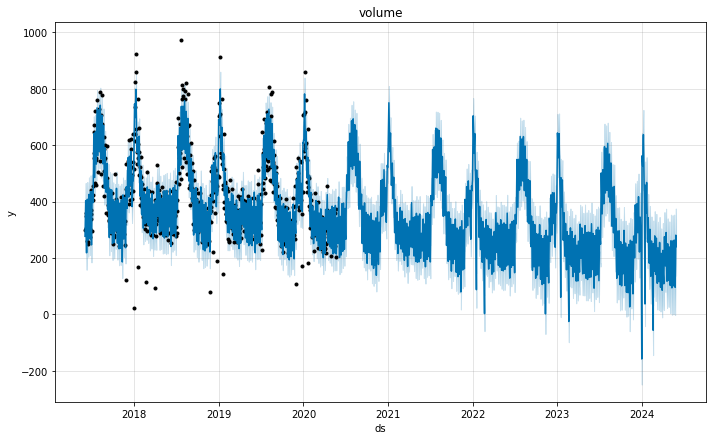

,ds,yhat_lower,yhat,yhat_upper,volume,error_prophet,volume_forecast,error_forecast,diff,mape_forecast,mape_prophet
0,2020-06-01,353.518099,415.729115,472.055716,351.0,65.0,331.0,20.0,-45.0,5.698006,18.441343
1,2020-06-02,295.590210,357.026760,414.647456,298.0,59.0,342.0,44.0,-15.0,14.765101,19.807638
2,2020-06-03,246.413853,304.081931,362.399364,307.0,3.0,278.0,29.0,26.0,9.446254,0.950511
3,2020-06-04,205.881934,261.946480,323.065680,226.0,36.0,264.0,38.0,2.0,16.814159,15.905522
4,2020-06-05,142.500130,201.506930,263.604859,276.0,74.0,186.0,90.0,16.0,32.608696,26.990243
...,...,...,...,...,...,...,...,...,...,...,...
240,2021-05-13,172.363299,231.559928,295.861722,304.0,72.0,327.0,23.0,-49.0,7.565789,23.828971
241,2021-05-14,125.282923,185.985586,250.166113,263.0,77.0,258.0,5.0,-72.0,1.901141,29.283047
242,2021-05-17,297.956051,355.966825,419.458966,367.0,11.0,428.0,61.0,50.0,16.621253,3.006315
243,2021-05-18,207.347109,267.884753,332.282463,324.0,56.0,406.0,82.0,26.0,25.308642,17.319521


,volume
old model,12.905197
prophet,16.672526
difference,-3.767330



new score of 16.67253, beat by 16.37622



,BRO-Complex,BRO,CS-Alaska,CS-John-Hancock,CS-Maryland,CS-National,PSG,RCS-PHONES,RIS,WISE
start_train,2020-03-01,2016-07-07,2018-11-19,2017-06-02,2019-03-26,2016-01-15,2017-09-12,2019-06-06,2016-08-17,2019-06-11
end_train,2021-05-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01
start_test,2021-05-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01
end_test,2021-05-14,2021-05-06,2021-05-18,2021-05-13,2021-05-11,2021-05-13,2021-05-05,2020-12-01,2021-05-20,2020-12-01
msm_mape,19.1581,15.6473,28.9589,12.8896,16.1281,19.1529,18.5326,13.0726,14.0354,7.56148
prophet_mape,17.4529,12.8996,26.2322,16.3762,14.6816,14.2635,15.6758,10.6453,11.8861,7.43751


CPU times: user 6.98 s, sys: 4.05 s, total: 11 s
Wall time: 6.55 s


In [111]:
#  @title Forecasting Tool
%%time

import warnings
warnings.simplefilter("ignore", RuntimeWarning)

file_path_dict = {'WISE': '../content/WISE-Contractual_aht_vol.csv',
'CS-Alaska': '../content/CS-Alaska_aht_vol.csv',
'CS-John-Hancock': '../content/CS-John-Hancock_aht_vol.csv',
'CS-Maryland': '../content/CS-Maryland_aht_vol.csv',
 'CS-National': '../content/CS-National_aht_vol.csv',
 'RIS': '../content/RIS_aht_vol.csv',
 'RCS-PHONES': '../content/RCS-PHONES_aht_vol.csv',
'BRO': '../content/BRO_aht_vol.csv',
'PSG':  '../content/PSG_aht_vol.csv',
'BRO-Complex':  '../content/BRO-Complex_aht_vol.csv'}

name_dict = {v:k for k,v in file_path_dict.items()}

business_unit = 'CS-John-Hancock' #@param ['WISE', 'CS-Alaska', 'CS-John-Hancock', 'CS-Maryland', 'CS-National', 'RIS', 'RCS-PHONES', 'BRO', 'PSG', 'BRO-Complex']
kpi = 'volume' #@param ['volume','aht','handle_time', 'abandonment_rate']
start_train = '2020-03-01' #@param {type:"date"}
end_train = '2020-06-01' #@param {type:"date"}
start_test = '2020-06-01' #@param {type:"date"}
end_test = '2021-05-18' #@param {type:"date"}
metric = 'mape' #@param ['mape', 'mae', 'rmse']
ci = 0.95 #@param {type:"number"}
train_with_holidays = True #@param {type:"boolean"}
end_test_now = True #@param {type:"boolean"}
data = file_path_dict[business_unit]

# try:    
#     date_dict = pd.read_json('/content/drive/My Drive/ris_data/date_dict.json')
# except:
#     pass

if business_unit != 'BRO-Complex':  
    start_train = date_dict[business_unit][0]

if end_test_now:    
    end_test = datetime.datetime.now().date().strftime('%Y-%m-%d')

performance = get_performance(name_dict, data, [kpi], 
                              start_train, end_train, start_test, 
                              end_test, metric, ci=ci, train_holidays=train_with_holidays)

preds = performance[file_path_dict[business_unit]][4]

score = performance[file_path_dict[business_unit]][1]

model = performance[file_path_dict[business_unit]][0]

new, old = score.loc['prophet', kpi], date_dict.loc['prophet_mape', business_unit]

if round(new, 5) < round(old, 5):
    print('\nprior score of {}, beat by {}\n'.format(round(old, 5), round(new, 5)))
    date_dict.loc[['start_train', 'end_train', 'start_test', 'end_test', 'prophet_mape',
                   'msm_mape'], business_unit] = [start_train, end_train, start_test, 
                                                  end_test, score.loc['prophet', kpi], 
                                                  score.loc['old model', kpi]]
    try:
        drive.mount('/content/drive')
        date_dict.to_json('/content/drive/My Drive/ris_data/date_dict' + '_'
        + start_test + '_' + end_test + '.json')
        date_dict.to_json('/content/drive/My Drive/ris_data/date_dict.json')
    except:
        print('no login')
elif round(new, 5) > round(old, 5):
    print('\nnew score of {}, beat by {}\n'.format(round(new, 5), round(old, 5)))

# send updated scores back to cloud
display(date_dict)


In [57]:
# reset score

# date_dict.loc[['msm_mape', 'prophet_mape'], business_unit] = [1000,1000]
# date_dict.to_json('/content/drive/My Drive/ris_data/date_dict.json')

# date_dict = pd.read_json('/content/drive/My Drive/ris_data/date_dict.json')
# date_dict

# Iterate to find best start training date

In [19]:
# #  @title Find Best start train Date
# # Clear date dict

# date_dict.loc['msm_mape', business_unit] = float('inf')
# date_dict.loc['prophet_mape', business_unit] = float('inf')

# holidays = pd.read_csv('../content/holidays.csv', parse_dates=['ACTIVITY DATE'])

# import heapq

# start = '2016-01-01' #@param {type:"date"}
# end = '2019-05-31' #@param {type:"date"}
# res = []
# for date in pd.date_range(start=start, end=end):
#     if date.dayofweek not in [5,6] and date.strftime('%Y-%m-%d') not in set(holidays.iloc[:,0].tolist()):
#         date = date.strftime('%Y-%m-%d')
#         p = get_performance(name_dict, data, [kpi], 
#                                     date, end_train, start_test, 
#                                     end_test, metric, ci=ci, train_holidays=train_with_holidays, 
#                             show_plots=False, show_table=False)
#         mape = p[file_path_dict[business_unit]][1].loc['prophet','volume']
#         res.append((date, mape))
#         local_min = heapq.nsmallest(1, res, key=lambda x: x[1])
#         print(date, mape, 'min:', local_min)

# min_ = min(res, key=lambda x: x[1])
# new = min_[1]
# new_date = min_[0]

# old = date_dict.loc['prophet_mape', business_unit]
# old_date = date_dict.loc['start_train', business_unit]

# new, old = score.loc['prophet', kpi], date_dict.loc['prophet_mape', business_unit]

# if round(new, 5) < round(old, 5):
#     print('\nprior score of {}, beat by {}\n'.format(round(old, 5), round(new, 5)))
#     date_dict.loc[['start_train', 'end_train', 'start_test', 'end_test', 'prophet_mape',
#                    'msm_mape'], business_unit] = [start_train, end_train, start_test, 
#                                                   end_test, score.loc['prophet', kpi], 
#                                                   score.loc['old model', kpi]]
#     try:
#         drive.mount('/content/drive')
#         date_dict.to_json('/content/drive/My Drive/ris_data/date_dict' + '_'
#         + start_test + '_' + end_test + '.json')
#         date_dict.to_json('/content/drive/My Drive/ris_data/date_dict.json')
#     except:
#         print('no login')
# elif round(new, 5) > round(old, 5):
#     print('\nold score of {} on {} holds\n'.format(round(old, 5), old_date))

# display(pd.Series(dict(res)))


# pd.Series(dict(res)).plot()
# plt.title(business_unit + ' MAPE by start training date')
# plt.show()

# Visualize training and validation predictions

In [112]:
df = pd.read_csv('cleaned.csv', index_col=0, parse_dates=['date'])
f = pd.read_csv('forecast.csv', index_col=0, parse_dates=['ds'])
f = f.join(df.loc[start_train:])
# f = f.loc[:'2021-04-26']
f = f.rename(columns={'volume': 'y'})
df = f.loc[:, ['yhat_lower', 'yhat', 'yhat_upper', 'y', 'volume_forecast']]

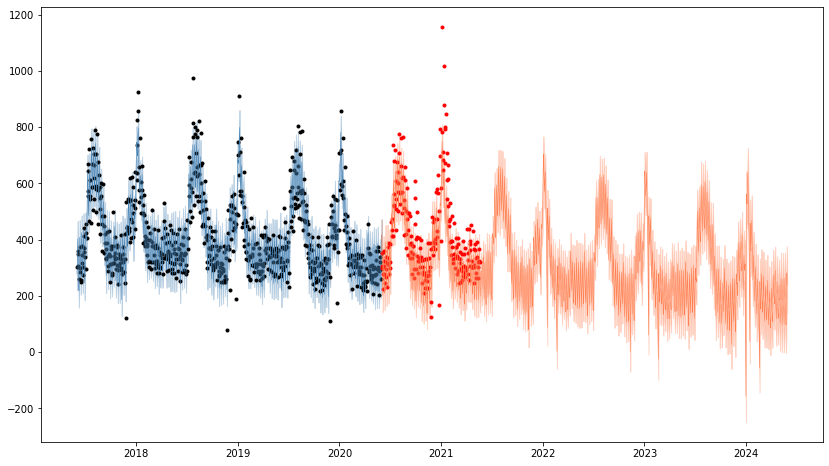

In [115]:
def plot_verif(verif, year_month='2020-06-01'):
    """
    plots the forecasts and observed data, the `year` argument is used to visualise 
    the division between the training and test sets. 
    Parameters
    ----------
    verif : pandas.DataFrame
        The `verif` DataFrame coming from the `make_verif` function in this package
    year : integer
        The year used to separate the training and test set. Default 2017
    Returns
    -------
    f : matplotlib Figure object
    """
    
    f, ax = plt.subplots(figsize=(14, 8))
    
    train = verif.loc[:year_month]
    try:
        ax.plot(train.index, train.y, 'ko', markersize=3)
        
        ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
        
        ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)

    

        test = verif.loc[year_month:]
        
        ax.plot(test.index, test.y, 'ro', markersize=3)
        
        ax.plot(test.index, test.yhat, color='coral', lw=0.5)
        
        ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
        
        year = year_month.split('-')[0]
        month = year_month.split('-')[1]
        ax.axvline(year_month, color='0.8', alpha=0.7)
        
        
        ax.grid(ls=':', lw=0.5)
    except:
        pass
    # return f

plot_verif(df)

In [22]:
df.to_csv('tableau_forecast.csv')

# Cross Validate

In [23]:
# cleaned = pd.read_csv('cleaned.csv', index_col=0, parse_dates=['date'])

# df = cleaned.copy()
# df = cleaned.copy().loc[:'2020-05']
# df = df.reset_index()
# df = df.rename(columns={'date': 'ds', 'volume': 'y'})
# df = df.loc[:, ['ds', 'y']]
# df.loc[:,'on_season'] = df.loc[:,'ds'].apply(is_holiday_season).values
# df.loc[:,'off_season'] = ~df.loc[:,'ds'].apply(is_holiday_season).values
# m = (Prophet(daily_seasonality=False, weekly_seasonality=False, 
#                 holidays_prior_scale=40, yearly_seasonality=30)
# .add_seasonality(name='weekly', period=5, fourier_order=6)
# # .add_seasonality(name='monthly', period=11, fourier_order=50)
# # .add_seasonality(name='quarterly', period=365.25/4, fourier_order=20)
# # .add_seasonality(name='yearly', period=365.25, fourier_order=20)
# .add_seasonality(name='weekly_on_season', period=7, fourier_order=6, condition_name='on_season')
# .add_seasonality(name='weekly_off_season', period=7, fourier_order=6, condition_name='off_season')
# )  

# m.add_country_holidays(country_name='US')
# m.fit(df)
# future = m.make_future_dataframe(periods=365 * 3)
# future = remove_holidays(future)
# future.loc[:, 'on_season'] = future.loc[:,'ds'].apply(is_holiday_season)
# future.loc[:, 'off_season'] = ~future.loc[:,'ds'].apply(is_holiday_season)
# forecast = m.predict(future)

cv_results = cross_validation(model, initial='1095.75 days', period='250 days', horizon='20 days')

# df_p = performance_metrics(cv_results)
# display(df_p.head())

mape_baseline = mean_absolute_percentage_error(cv_results.y, cv_results.yhat)
print('mape:', mape_baseline)

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-09-02 00:00:00 and 2020-05-09 00:00:00



mape: 7.8070046295646


# Check daily updated model forecasts for next day
Mape does not improve with daily iteration

In [24]:
#  @title Run updating daily check for test period

# %%time

# file_path_dict = {'WISE': '../content/WISE-Contractual_aht_vol.csv',
# 'CS-Alaska': '../content/CS-Alaska_aht_vol.csv',
# 'CS-John-Hancock': '../content/CS-John-Hancock_aht_vol.csv',
# 'CS-Maryland': '../content/CS-Maryland_aht_vol.csv',
#  'CS-National': '../content/CS-National_aht_vol.csv',
#  'RIS': '../content/RIS_aht_vol.csv',
#  'RCS-PHONES': '../content/RCS-PHONES_aht_vol.csv',
# 'BRO': '../content/BRO_aht_vol.csv',
# 'PSG':  '../content/PSG_aht_vol.csv',
# 'BRO-Complex':  '../content/BRO-Complex_aht_vol.csv'}

# name_dict = {v:k for k,v in file_path_dict.items()}

# business_unit = 'RIS' #@param ['WISE', 'CS-Alaska', 'CS-John-Hancock', 'CS-Maryland', 'CS-National', 'RIS', 'RCS-PHONES', 'BRO', 'PSG', 'BRO-Complex']
# kpi = 'volume' #param ['volume','aht','handle_time', 'abandonment_rate']
# start_train = '2017-10-13' #@param {type:"date"}
# end_train = '2020-06-01' #@param {type:"date"}
# start_test = '2020-06-01' #@param {type:"date"}
# end_test = '2021-04-01' #@param {type:"date"}
# metric = 'mape' #@param ['mape', 'mae', 'rmse']
# ci = 0.95 #@param {type:"number"}
# train_with_holidays = False #@param {type:"boolean"}
# data = file_path_dict[business_unit]

# res = {}
# os.makedirs('daily', exist_ok=True)
# for day in daily_update['ds']:
#     date = day.strftime("%Y-%m-%d")
#     print(date)
#     end_train = start_test = date
#     p = get_performance(name_dict, data, [kpi], 
#                         start_train, end_train, start_test, 
#                         end_test, metric, ci=ci, train_holidays=train_with_holidays,
#                         show_plots=False, show_table=False)
#     s = p['../content/RIS_aht_vol.csv'][4]
#     daily_score = s[['ds', 'yhat', 'volume', 'volume_forecast', 'mape_prophet', 'mape_forecast']]
#     daily_score.to_csv('daily/' + date + '.csv')
#     res[date] = daily_score[['ds','mape_prophet']]

# # print(res)
# # daily_mape = pd.Series(res)
# # display(daily_mape)
# # # daily_mape.to_csv('final_daily_mape.csv')

# # Calculate mean scores as they progress 

# from collections import defaultdict
# days_scores = defaultdict(list)
# for day in daily_update['ds']:
#     date = day.strftime("%Y-%m-%d")
#     for _date, score in res[date].iterrows():
#         string_date = score['ds'].strftime("%Y-%m-%d")
#         days_scores[string_date].append(score['mape_prophet'])

# # max rows to create a dataframe
# print(max([len(x) for x in days_scores.values()]))
# for day, score in days_scores.items():
#     plt.boxplot(score)
#     plt.title(day)
#     plt.show()
# mean_mape = {}

# for date, mape in days_scores.items():
#     # pd.Series(data=mape, index=[date]).plot.box()
#     # plt.title(date)
#     # plt.show()
#     mean_mape[date] = np.mean(mape)

# pd.Series(mean_mape).to_csv('mean_mape_by_day.csv')

# display(pd.Series(mean_mape))
# display(pd.Series(mean_mape).describe())

# Analyze Prediction performance as cumulative Percentage Error

in terms of the sums by interval

In [25]:
preds = preds.set_index('ds')

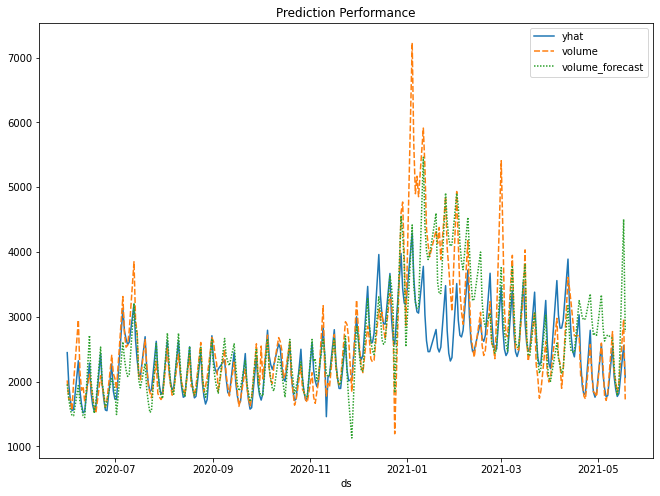

In [26]:
plt.figure(figsize=(11, 8))
_ = sns.lineplot(data=preds[['yhat', kpi, kpi+'_forecast']])
plt.title('Prediction Performance')
plt.show()

In [27]:
pe = ((preds['volume'] - preds['yhat']) / preds['volume'])

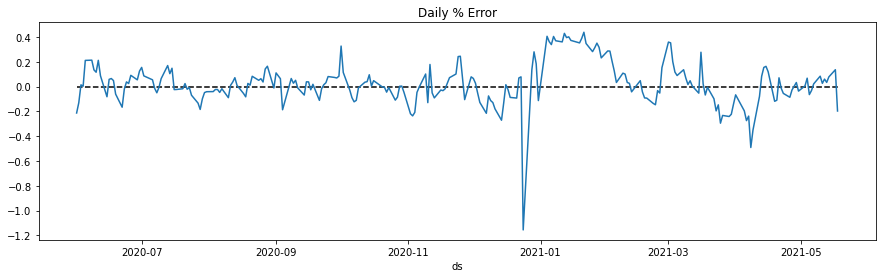

In [28]:
plt.figure(figsize=(15,4))
sns.lineplot(data=pe)
plt.hlines(y=0, xmin=pe.index.min(), xmax=pe.index.max(), linestyles='dashed')
plt.title('Daily % Error')
plt.show()

# Look at monthly forecast rollup

In [29]:
monthly_sum = preds.resample('MS').sum()
monthly_sum.index = monthly_sum.index.date

In [30]:
monthly_pe = ((monthly_sum['volume'] - monthly_sum['yhat']) / monthly_sum['volume'])
monthly_pe.name = '% error'
monthly_pe.describe()

count    12.000000
mean      0.043566
std       0.107284
min      -0.061667
25%       0.010168
50%       0.020015
75%       0.043959
max       0.366335
Name: % error, dtype: float64

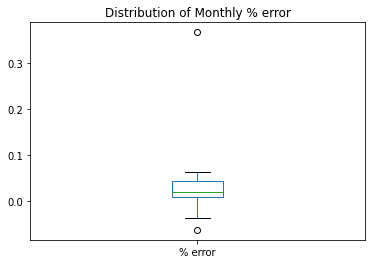

In [31]:
monthly_pe.plot.box()
plt.title('Distribution of Monthly % error')
plt.show()

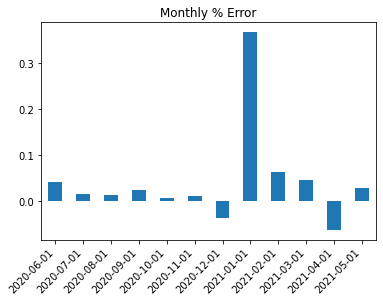

In [32]:
ax = monthly_pe.plot.bar()
plt.title('Monthly % Error')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
plt.show()

## Look at Weekly forecast rollup

In [33]:
weekly_sum = preds.resample('W').sum()
weekly_sum.index = weekly_sum.index.date

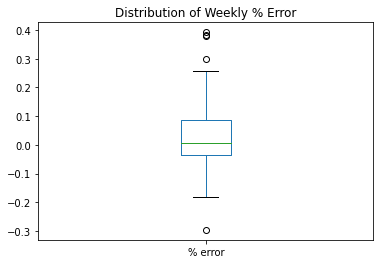

In [34]:
weekly_pe = ((weekly_sum['volume'] - weekly_sum['yhat']) / weekly_sum['volume'])
weekly_pe.name = '% error'
weekly_pe.plot.box()
plt.title('Distribution of Weekly % Error')
plt.show()

In [35]:
weekly_pe.describe()

count    51.000000
mean      0.032198
std       0.139352
min      -0.296425
25%      -0.034538
50%       0.005005
75%       0.086273
max       0.392159
Name: % error, dtype: float64

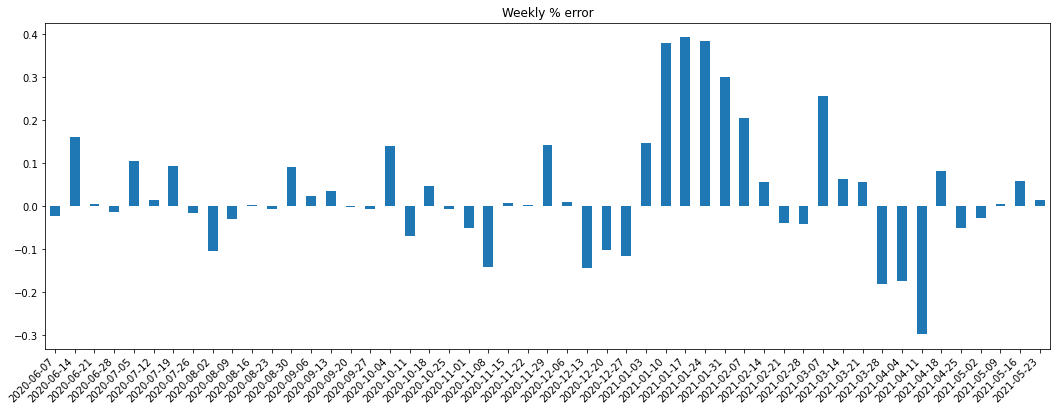

In [36]:
plt.figure(figsize=(18,6))
ax = weekly_pe.plot.bar()
plt.title('Weekly % error')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
plt.show()

# Next Day performance benchmarks

In [37]:
preds[['mape_forecast', 'mape_prophet']].describe()

,mape_forecast,mape_prophet
count,244.000000,244.000000
mean,13.764198,11.956677
std,13.862749,12.669286
min,0.102617,0.219035
25%,3.401561,3.557366
50%,9.134792,8.191442
75%,19.217781,15.512920
max,71.750433,115.634078


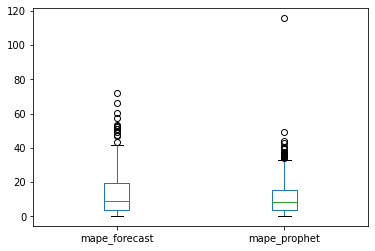

In [38]:
_ = preds[['mape_forecast', 'mape_prophet']].plot.box()

# The predictions tool below returns rolling forecasts

You can adjust the frequency of the predictions to weekly, monthly, bi-weekly, every 3,6 or 12 weeks, quarterly, or every 6 months, and a number of other inputs.

In [39]:
#  @title Predictions Tool
import os
def get_rolling_forecast(path, kpi, frequency='MS'):
    preds = pd.read_csv(path, index_col=0, parse_dates=['ds'])
    preds.index = preds['ds']
    p = preds.resample(frequency).sum()

    names = path.split(kpi)
    
    folder = '../content/rolling_forecasts/'

    p['mape_forecast'] = (p[kpi] - p[kpi+'_forecast']).abs() / p[kpi] * 100
    p['mape_prophet'] = (p[kpi] - p['yhat']).abs() / p[kpi] * 100
    _path = path.split('_')
    print('start train:', _path[1])
    print('end train:', _path[2])
    print('test start:', _path[3])
    print('test end:', _path[4])
    display(p[['yhat', kpi, kpi+'_forecast', 'mape_forecast', 'mape_prophet']])
    os.makedirs(folder, exist_ok=True)
    # p.to_csv(folder+'{}_{}_{}_{}.csv'.format(kpi, frequency, names[3], names[4]))
    
    print(frequency+'\n')
    # print('{} trained on {} to {}'.format(kpi, names[1], names[2]))
    # print('tested on {} to {}'.format(names[3], names[4]))
    print('MAPE_prophet:', mean_absolute_percentage_error(p[kpi], p['yhat']))
    print('MAPE_forecast:', mean_absolute_percentage_error(p[kpi], p[kpi + '_forecast']))
    # print('RMSE:', np.sqrt(mean_squared_error(p[kpi], p['yhat'])))
    print('*'*100)
    print('\n')
    return p[['yhat', kpi, kpi+'_forecast', 'mape_forecast', 'mape_prophet']] 

frequency = 'MS' #@param ['MS', '6M', 'W', '2W', '3W', '6W', '12W', 'Q'] {allow-input: true}
path = 'volume_2016-03-10_2020-06-01_2020-06-01_2021-02-25_RIS.csv'
folder = '../content/predictions/'
kpi = 'volume' 

results = []
for path in os.listdir(folder):
    prophet = get_rolling_forecast(folder+path, kpi, frequency=frequency)
    results.append(prophet)



start train: 2016-08-17
end train: 2020-06-01
test start: 2020-06-01
test end: 2021-05-19


,yhat,volume,volume_forecast,mape_forecast,mape_prophet
ds,,,,,
2020-06-01,40362.442001,42178.0,39667.0,5.953341,4.304514
2020-07-01,50485.737991,51295.0,46529.0,9.291354,1.577663
2020-08-01,43120.331017,43711.0,44166.0,1.040928,1.351305
2020-09-01,41826.358938,42866.0,44140.0,2.972052,2.425328
2020-10-01,46607.242301,46929.0,45115.0,3.865414,0.685627
2020-11-01,44376.115866,44882.0,44241.0,1.428189,1.127143
2020-12-01,65895.680802,63621.0,64472.0,1.337609,3.575362
2021-01-01,55325.325847,87310.0,75745.0,13.245905,36.633460
2021-02-01,54073.186993,57742.0,66099.0,14.473001,6.353803


MS

MAPE_prophet: 5.980245635113727
MAPE_forecast: 7.821738793314234
****************************************************************************************************




# Begin Sum of MAPE Monthly comparison to RIS MSM

snag the monthly MAPE for MSM forecasts from the end of May 2020 through February 2021

In [40]:
monthly = pd.read_csv('monthly_volume.csv')
monthly = monthly.set_index('Date')
prophet.loc[:'2021-02','mape_erlang'] = np.abs(np.diag(monthly)* 100)

display(monthly)

,1,2,3,4,5,6,7,8,9
Date,,,,,,,,,
2020-05,-0.173113,-0.208990,-0.208990,-0.208990,-0.208990,-0.208990,-0.208990,NaN,NaN
2020-06,0.231401,0.170448,0.156627,0.156627,0.156627,0.156627,0.156627,0.156627,NaN
2020-07,0.100838,0.079132,0.079132,-0.002541,-0.002541,-0.002541,-0.002541,-0.002541,-0.002541
2020-08,0.084961,0.084961,0.001749,0.001749,-0.029116,-0.029116,-0.029116,-0.029116,-0.029116
2020-09,0.215224,0.215224,0.215224,0.146734,0.146734,0.120351,0.120351,0.120351,0.120351
2020-10,0.213567,0.213567,0.213567,0.213567,0.136807,0.136807,0.110104,0.110104,0.110104
2020-11,0.154726,0.154726,0.154726,0.154726,0.154726,0.130969,0.130969,0.104097,0.104097
2020-12,0.265589,0.265589,0.265589,0.265589,0.265589,0.265589,0.243726,0.243726,0.243726
2021-01,0.376221,0.376221,0.376221,0.376221,0.376221,0.376221,0.388935,0.388935,0.388935


In [41]:
# add april
prophet.loc['2021-03-01', 'mape_erlang'] = 10.5

# Upload ARIMA results and compare

In [42]:
arima = pd.read_csv('arima_results_volume.csv')
arima = arima.loc[:10,:]
scores = pd.concat([prophet[:'2021-05'].reset_index(), arima[['mape', 'forecast']]],1)
scores.rename(columns={'mape': 'mape_arima', 'forecast': 'arima_forecast',
                       'mape_forecast': 'mape_erlang_daily', 
                       'yhat': 'prophet_forecast',
                       'volume_forecast': 'erlang_forecast'}, inplace=True)
display(scores)


,ds,prophet_forecast,volume,erlang_forecast,mape_erlang_daily,mape_prophet,mape_erlang,mape_arima,arima_forecast
0,2020-06-01,40362.442001,42178.0,39667.0,5.953341,4.304514,17.311316,29.482131,29743.026877
1,2020-07-01,50485.737991,51295.0,46529.0,9.291354,1.577663,17.044844,1.464942,50544.543606
2,2020-08-01,43120.331017,43711.0,44166.0,1.040928,1.351305,7.913174,3.667621,45314.153730
3,2020-09-01,41826.358938,42866.0,44140.0,2.972052,2.425328,0.174901,10.781062,38245.482256
4,2020-10-01,46607.242301,46929.0,45115.0,3.865414,0.685627,14.673422,2.656990,48180.004912
5,2020-11-01,44376.115866,44882.0,44241.0,1.428189,1.127143,13.680745,4.519907,46910.624873
6,2020-12-01,65895.680802,63621.0,64472.0,1.337609,3.575362,13.096881,5.783888,61062.404470
7,2021-01-01,55325.325847,87310.0,75745.0,13.245905,36.633460,24.372592,29.077390,64243.828072
8,2021-02-01,54073.186993,57742.0,66099.0,14.473001,6.353803,38.893521,25.115117,73991.829060
9,2021-03-01,62254.380950,65304.0,63944.0,2.082568,4.669881,10.500000,16.903802,76342.858795


In [43]:
formatted = scores.loc[:, ['ds', 'mape_prophet', 'mape_erlang', 'mape_arima']]

formatted.loc[:, 'ds'] = formatted['ds'].dt.strftime('%b-%Y').values
formatted = formatted.rename(columns={'mape_erlang': 'mape_MSM', 'ds': 'month-year'})

display(formatted.set_index('month-year')[:].round(2))

formatted.set_index('month-year')[:].round(2).to_csv('test_by_month.csv', index=False)

,mape_prophet,mape_MSM,mape_arima
month-year,,,
Jun-2020,4.30,17.31,29.48
Jul-2020,1.58,17.04,1.46
Aug-2020,1.35,7.91,3.67
Sep-2020,2.43,0.17,10.78
Oct-2020,0.69,14.67,2.66
Nov-2020,1.13,13.68,4.52
Dec-2020,3.58,13.10,5.78
Jan-2021,36.63,24.37,29.08
Feb-2021,6.35,38.89,25.12


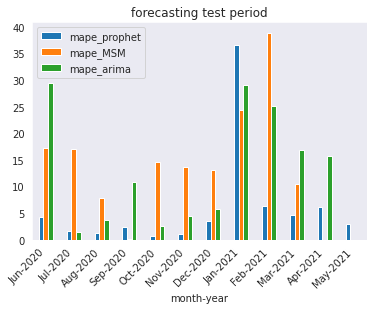

In [44]:
sns.set_style(style='dark')

ax = formatted.plot.bar(x='month-year')

plt.title('forecasting test period')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
plt.show()

In [45]:
scores[['mape_prophet',	'mape_erlang', 'mape_arima']].describe().round(2)

,mape_prophet,mape_erlang,mape_arima
count,12.00,10.00,11.00
mean,5.98,15.77,13.21
std,9.84,10.32,10.75
min,0.69,0.17,1.46
25%,1.52,11.15,4.09
50%,3.23,14.18,10.78
75%,5.04,17.24,21.01
max,36.63,38.89,29.48


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



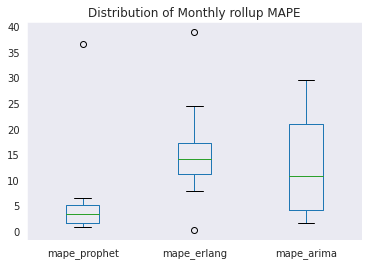

In [46]:
scores[['mape_prophet',	'mape_erlang', 'mape_arima']].values().plot.box()
plt.title('Distribution of Monthly rollup MAPE')
plt.show()

# Prophet model beats arima and erlang model at long term forecasts


# Create Future predictions

In [47]:
future = performance['../content/RIS_aht_vol.csv'][2]
future = future.set_index('ds')
future['2021-03':][['yhat_lower', 'yhat', 'yhat_upper']].astype(int)

,yhat_lower,yhat,yhat_upper
ds,,,
2021-05-19,1369,1823,2261
2021-05-20,1225,1669,2102
2021-05-21,1227,1687,2125
2021-05-24,2096,2514,2974
2021-05-25,1639,2102,2550
...,...,...,...
2024-05-22,783,2712,4604
2024-05-23,714,2610,4542
2024-05-24,772,2686,4526


In [48]:
future['2021-03':][['yhat_lower', 'yhat', 'yhat_upper']].astype(int).to_csv('RIS_future_predictions_handle_time.csv')